In [75]:
# !source env/bin/activate
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import shutil
from tqdm.notebook import tqdm
# Créer le dossier srincipal
os.makedirs('1.DataSet/export', exist_ok=True)
os.makedirs('1.DataSet/image', exist_ok=True)
os.makedirs('1.DataSet/video', exist_ok=True)

In [61]:
#cliquer sur exécurter tout pour lancer le programme


FOLDER_DATA_EXPORT = "1.DataSet/export"
FOLDER_DATA_IMPORT = "1.DataSet/Image"
#parametre = 
INFO_DEBUG = True

FOLDER_IMAGE = [
    '1.DataSet/Image/test',
    '1.DataSet/Image/train',
    '1.DataSet/Image/val'
]


#Passe les image dans ResNet50 pour avoir les features (prend du calcule mais les feature sont sauvegarder dans un csv par dossier)
GET_FEATURE = True 
REPLACE_FEATURE_IF_EXISTE  = False 


GET_CLUSTER = True
EXPORT = True

# Paramètres Différentes tailles de liste
        #P_min = 0.1    Pourcentage minimal
        #P_max = 0.5   Pourcentage maximal
        #a = 0.05   Facteur de décroissance exponentielle plus il est grand, plus la décroissance est rapide
#Cluster : 
NB_CLUSTER = 40  # 1 ou 0 pour desactiver K-means
P_MIN = 0.2
P_MAX = 0.8
FACTEUR_CROISSANCE = 0.1



#Calcule des différence de tout Notre DataSet selectionner (cluster ou hasard)
EXPERIENCE_SCORE_SIMILITUDE = False
NB_EXPERIENCE_SIMILITUDE = 15



In [62]:
class PrepareData:
    def __init__(self):
        self.model , self.preprocess = self.start_resnet50()
        self.nb_image = 0

    def start_resnet50(self):
        # Charger le modèle ResNet50 pré-entraîné
        model = models.resnet50(pretrained=True)

        # Supprimer la dernière couche de classification
        model = nn.Sequential(*list(model.children())[:-1])  

        # Mettre le modèle en mode évaluation
        model.eval()  

        # Définir les transformations pour l'image a effecuter (correspondant à l'entrée du modèle)
        preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
        )
        return model, preprocess
    
    #Fonction pour extraire les caractéristiques d'une images
    def tool_get_image_features(self,img_path):
        """Fonction pour extraire les caractéristiques d'une image"""
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.preprocess(img).unsqueeze(0)  # Appliquer les transformations et ajouter une dimension batch
        with torch.no_grad():
            features = self.model(img_tensor)  # Extraire les caractéristiques
        return features.squeeze().numpy()  # Retourner les caractéristiques sous forme de tableau 1D
    
    def if_contient_feature_csv_ou_ne_pas_remplacer(self,path_folder : list):
        REPLACE_FEATURE_IF_EXISTE
        if os.path.exists(f"{path_folder}/features.csv") and not  REPLACE_FEATURE_IF_EXISTE:
            return True
        return False

    #Recupere tout les feature de tout les dossier et crée un fichier csv par dossier
    def action_get_all_features(self,images_folders : list):
        for image_folder in tqdm(images_folders, desc="Traitement des dossiers"):
            if  self.if_contient_feature_csv_ou_ne_pas_remplacer(image_folder):
                    continue
            image_features_list = []
            image_names_list = []
            image_path_list = []
            image_files = [img for img in os.listdir(image_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
            for img_name in tqdm(image_files, desc=f"Traitement des images dans {image_folder}", leave=False):
                img_path = os.path.join(image_folder, img_name)
                features = self.tool_get_image_features(img_path)  # Extraire les caractéristiques de l'image
                image_path_list.append(img_path)
                image_features_list.append(features)  # Ajouter les caractéristiques à la liste
                image_names_list.append(img_name)  # Ajouter le nom de l'image à la liste
                self.nb_image += 1

            #Creation du csv features  
            df = pd.DataFrame(image_features_list)
            df['image_name'] = image_names_list 
            df['image_path'] = image_path_list 
            df.to_csv(f'{image_folder}/features.csv', index=False)
            print(f"{image_folder} feature crée avec succès")
        self.reset_nb_image = True
    
    #Vas chercher tout les feature csv les concate et 
    
    def action_get_cluster(self,images_folders : list,num_clusters = NB_CLUSTER):
        df_all_value = pd.DataFrame()

        for image_folder in tqdm(images_folders, desc="Chargement des features"):
            # Charger les caractéristiques extraites
            df_local_value = pd.read_csv(f"{image_folder}/features.csv")
            df_all_value = pd.concat((df_all_value,df_local_value.copy()),ignore_index=True)
        
        
        # Extraire les vecteurs de caractéristiques sans la colonne des noms d'images
        df_all_feature = df_all_value.drop(columns=['image_name','image_path']).values

        # Appliquer le clustering K-means
        if  NB_CLUSTER != 1 & 0:
            kmeans = KMeans(n_clusters=num_clusters)
            clusters = kmeans.fit_predict(df_all_feature)  # Regrouper les caractéristiques en clusters
        else:
            clusters = np.zeros(df_all_feature.shape[0])
        # Ajouter les résultats du clustering au DataFrame
        df_all_value['cluster'] = clusters
    
        df_all_value.to_csv(f'clustered_features_all.csv', index=False)

In [63]:
class ClusterTraitement:
    def __init__(self,path_all_feature):
        self.df_all_images_features = pd.DataFrame()
        self.df_random_all_value = pd.DataFrame()
        self.df_random_features = pd.DataFrame()
        self.last_size_split = 0
        self.semblable_score = 0
        self.start_load_all_features(path_all_feature)

    def get_last_index_export(self):
       return len(os.listdir(FOLDER_DATA_EXPORT))
    #calcule la difference de similitude entre 2 features

    @staticmethod
    def calc_cosine_similarity(feature_1 , feature_2):
    # Calculer la distance cosinus directement sans normalisation
        return 1 - cosine(feature_1, feature_2)
    
    # Calcul des pourcentages pour différentes tailles de liste avec la fonction exponentielle
    @staticmethod
    def calc_exponential_dynamic_percentage(n, P_min =P_MIN, P_max=P_MAX, a=FACTEUR_CROISSANCE) ->float:
        # Paramètres Différentes tailles de liste
        #P_min = 0.1    Pourcentage minimal
        #P_max = 0.5   Pourcentage maximal
        #a = 0.05   Facteur de décroissance exponentielle plus il est grand, plus la décroissance est rapide
        # Utilisation de la fonction exponentielle pour moduler le pourcentage
        P_n = P_min + (P_max - P_min) * np.exp(-a * n)
        return P_n
    
    #Donne le nombre d'image a récuperer par cluster 
    def tool_how_get_image_par_cluster(self,n_elements : pd.Series) -> np.int8:
        #P_min = 0.1    Pourcentage minimal
        #P_max = 0.5   Pourcentage maximal
        #a = 0.05   Facteur de décroissance exponentielle plus il est grand, plus la décroissance est rapide
        # exponential_percentages = np.array([exponential_dynamic_percentage(n, p_min, p_max, a) for n in n_elements])
        exponential_percentages = n_elements.apply(self.calc_exponential_dynamic_percentage)

        # Nombre d'images à récupérer par cluster si le cluster est vide il prend 1 image
        nb_image_a_tirer = (n_elements*exponential_percentages).round()
        
        nb_image_a_tirer[nb_image_a_tirer ==0 ] = 1
        all_data = pd.concat([n_elements,nb_image_a_tirer,exponential_percentages],axis=1)
        #pourcentage d'image garder, nombre d'image garder , nombre d'image total
        if INFO_DEBUG:
            all_data.columns = ['n_elements', 'nb_image_a_tirer', 'exponential_percentages']
            print(f" ta mére : {all_data}")
        
        return nb_image_a_tirer.sort_index().to_numpy(int)

    def start_load_all_features(self,path_all_feature):
        #Chargement des features
        self.df_all_images_features = pd.read_csv('clustered_features_all.csv')

        #recupe le % d'image a recuperer par cluster si on a pas de cluster on le % dans tout notre dataset
        nb_image_a_piocher_par_cluster = self.tool_how_get_image_par_cluster(self.df_all_images_features["cluster"].value_counts())

        if INFO_DEBUG:
            #Affiche le nombre d'image a piocher par cluster
            print(f"{nb_image_a_piocher_par_cluster=}")

        Index_aletoire_par_cluster = []
        for n_similarity in range(NB_CLUSTER):
            index_cluster_n = self.df_all_images_features.query(f"cluster == {n_similarity}").index.to_numpy(int)
            # Pioche plusieurs index en une seule fois sans remplacement
            indexes_pioches = np.random.choice(index_cluster_n, size=int(nb_image_a_piocher_par_cluster[n_similarity]), replace=False)
            Index_aletoire_par_cluster.extend(indexes_pioches)
            print(f"{n_similarity=}")

        if INFO_DEBUG : 
            #verifie qu'il n'y a pas d'index doublon
            print((f"{(pd.DataFrame(Index_aletoire_par_cluster).value_counts() == 1).unique()=}"))


        #On selection les image selectionner par cluster 
        self.df_random_all_value = self.df_all_images_features.loc[Index_aletoire_par_cluster].copy()

        #On reset l'index pour travaillier avec plus facilement avec
        self.df_random_all_value.reset_index(drop=True, inplace=True)

        #on isole les features des path et des nom d'image
        self.df_random_features = self.df_random_all_value[self.df_all_images_features.columns[:-3]]

    def tool_split_data(self,data : pd.DataFrame,shuffle = False) -> tuple[pd.DataFrame.index,pd.DataFrame.index]:
        data_index =  data.index.to_numpy(int).copy()

        #je randomise les index avant la séparation en 2 lots
        if shuffle:
            data_index = self.tool_shuffle_index(data_index)

        if data_index.shape[0] % 2 != 0:
            data_index = data_index[:-1]  # On retire le dernier élément pour avoir un nombre pair

        # Calcul du milieu
        millieu = data_index.shape[0] // 2
        
        # On divise en deux parts égales
        Lot_1_index = data_index[:millieu]
        Lot_2_index = data_index[millieu:]

        Lot_1_index.shape[0]
        Lot_2_index.shape[0]

        return Lot_1_index,Lot_2_index

    @staticmethod
    def tool_shuffle_index(data_index : pd.DataFrame.index) -> pd.DataFrame.index:
        return np.random.permutation(data_index)
    
    def action_exp_similarity_score_data_set(self,nb_experience = NB_EXPERIENCE_SIMILITUDE):

        #on split les index dans l'ordre
        Lot_1_index,Lot_2_index = self.tool_split_data(self.df_random_features,shuffle=True)
        Result_exp_similarity = np.zeros((NB_EXPERIENCE_SIMILITUDE,Lot_1_index.shape[0]))

        #on utilis les index d'expérience pour trouver les score minimum
        index_exp = []
        for n_exp in range(nb_experience):
            Lot_1_index_shuffle,Lot_2_index_shuffle = self.tool_split_data(self.df_random_features,shuffle=True)
            #on recupere les feature dans les data
            feature_1 = self.df_random_features.loc[Lot_1_index_shuffle].to_numpy()
            feature_2 = self.df_random_features.loc[Lot_2_index_shuffle].to_numpy()
            index_exp.append(np.concatenate((Lot_1_index,Lot_2_index)))

            # calcule 
            for n_similarity in range(feature_1.shape[0]):
                Result_exp_similarity[n_exp][n_similarity] = self.calc_cosine_similarity(feature_1[n_similarity] , feature_2[n_similarity])


        self.semblable_score = pd.DataFrame(Result_exp_similarity.mean(axis=1)).mean()

    def proc_id_index_in_name(self : pd.DataFrame): 
        #je change le nom  pour avoir un nom unique mais pouvoir retrouver les image d'origine
        df_new_name_file =  self.df_random_all_value["image_name"].str.split(".",expand=True)
        # # on concatene nos chaine (il faut que se soit des série en str pour que sa marche)
        df_new_name_file = df_new_name_file.index.to_series().astype(str)+ '_' + df_new_name_file[0] + '.' + df_new_name_file[1].drop(columns=1)
        self.df_random_all_value["new_image_name"] = df_new_name_file

    def proc_export_path_image_name(self): 
        last_export_patch = os.path.join(FOLDER_DATA_EXPORT,str(self.get_last_index_export()))
        os.makedirs(last_export_patch, exist_ok=True)
        self.df_random_all_value["image_path_export"]=  last_export_patch+"/"+self.df_random_all_value["new_image_name"]

    def action_export_cluster_image_random(self,folder_data_export =FOLDER_DATA_EXPORT): 
        self.proc_id_index_in_name()
        self.proc_export_path_image_name()
        folder_data_export = os.path.join(folder_data_export, str(self.get_last_index_export()-1))

        nom_fichier = f'0.similitude_{str(self.semblable_score.values)}.txt"'
        # Créer le chemin complet du fichier
        chemin_fichier_score = os.path.join(folder_data_export, nom_fichier)

        # Créer un fichier texte vide
        with open(chemin_fichier_score, 'w'):
            pass  # Ne rien faire, juste créer le fichier

        print(f"Fichier score créé")

        # Transférer les fichiers en changeant leur nom
        for index, row in self.df_random_all_value.iterrows():
            source_file = row['image_path']
            destination_file = row['image_path_export']
            try:
                shutil.copy(source_file, destination_file)
                print(f"Transféré : {source_file} -> {destination_file}")
            except Exception as e:
                print(f"Erreur lors du transfert de {source_file} : {e}")

        print("Transfert terminé.")


In [64]:
#partie logique 

df_data = PrepareData()
df_data

if GET_FEATURE :
    df_data.action_get_all_features(FOLDER_IMAGE)
print(f"TT_Image {df_data.nb_image}")

if GET_CLUSTER:
    df_data.action_get_cluster(FOLDER_IMAGE,NB_CLUSTER)

cluster =  ClusterTraitement("clustered_features_all.csv")

if EXPERIENCE_SCORE_SIMILITUDE:
    cluster.action_exp_similarity_score_data_set()

if EXPORT:
    cluster.action_exp_similarity_score_data_set()
    cluster.action_export_cluster_image_random()


/Users/vigreu8/miniconda3/envs/pipevd/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vigreu8/miniconda3/envs/pipevd/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Traitement des dossiers:   0%|          | 0/3 [00:00<?, ?it/s]

TT_Image 0


Chargement des features:   0%|          | 0/3 [00:00<?, ?it/s]

 ta mére :          n_elements  nb_image_a_tirer  exponential_percentages
cluster                                                       
9               184              37.0                 0.200000
8               169              34.0                 0.200000
18              116              23.0                 0.200005
5               116              23.0                 0.200005
12              113              23.0                 0.200007
7               105              21.0                 0.200017
13              105              21.0                 0.200017
21               98              20.0                 0.200033
1                96              19.0                 0.200041
36               95              19.0                 0.200045
32               95              19.0                 0.200045
27               94              19.0                 0.200050
22               89              18.0                 0.200082
28               88              18.0       

In [65]:
cluster.df_random_all_value.shape

(614, 2053)

In [66]:
print(cluster.semblable_score)


0    0.681034
dtype: float64


In [ ]:
data = pd.read_csv("clustered_features_all.csv").sort_values(by="cluster").loc[:,["image_path","cluster"]]
# display(data.head(5))
# display(data.loc[:,"cluster"].value_counts())


def select_origine(df,folder_path : str) -> pd.Series:
    return data["image_path"].str.contains(folder_path)

l_origin = ("train","val","test")
data["origin"] = None
for origin_name in l_origin:
    si_origin = select_origine(data,origin_name)
    data["origin"].loc[si_origin] = origin_name

data.head(5)





/var/folders/cf/hkp86d6d1z732qc113jngvym0000gn/T/ipykernel_76936/1679612630.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["origin"].loc[si_origin] = origin_name
/var/folders/cf/hkp86d6d1z732qc113jngvym0000gn/T/ipykernel_76936/167

,image_path,cluster,origin
1525,1.DataSet/Image/train/70d57411-0de5-4980-a54b-...,0,train
194,1.DataSet/Image/test/46171db5-620d-48d5-8f3d-6...,0,test
2552,1.DataSet/Image/val/03212b7c-09df-46fa-b5ba-f6...,0,val
989,1.DataSet/Image/train/2b70d9a9-5b9a-475e-a9ef-...,0,train
73,1.DataSet/Image/test/191093cf-7254-47d3-a747-b...,0,test


/var/folders/cf/hkp86d6d1z732qc113jngvym0000gn/T/ipykernel_76936/503178928.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='count', data=cluster_df,


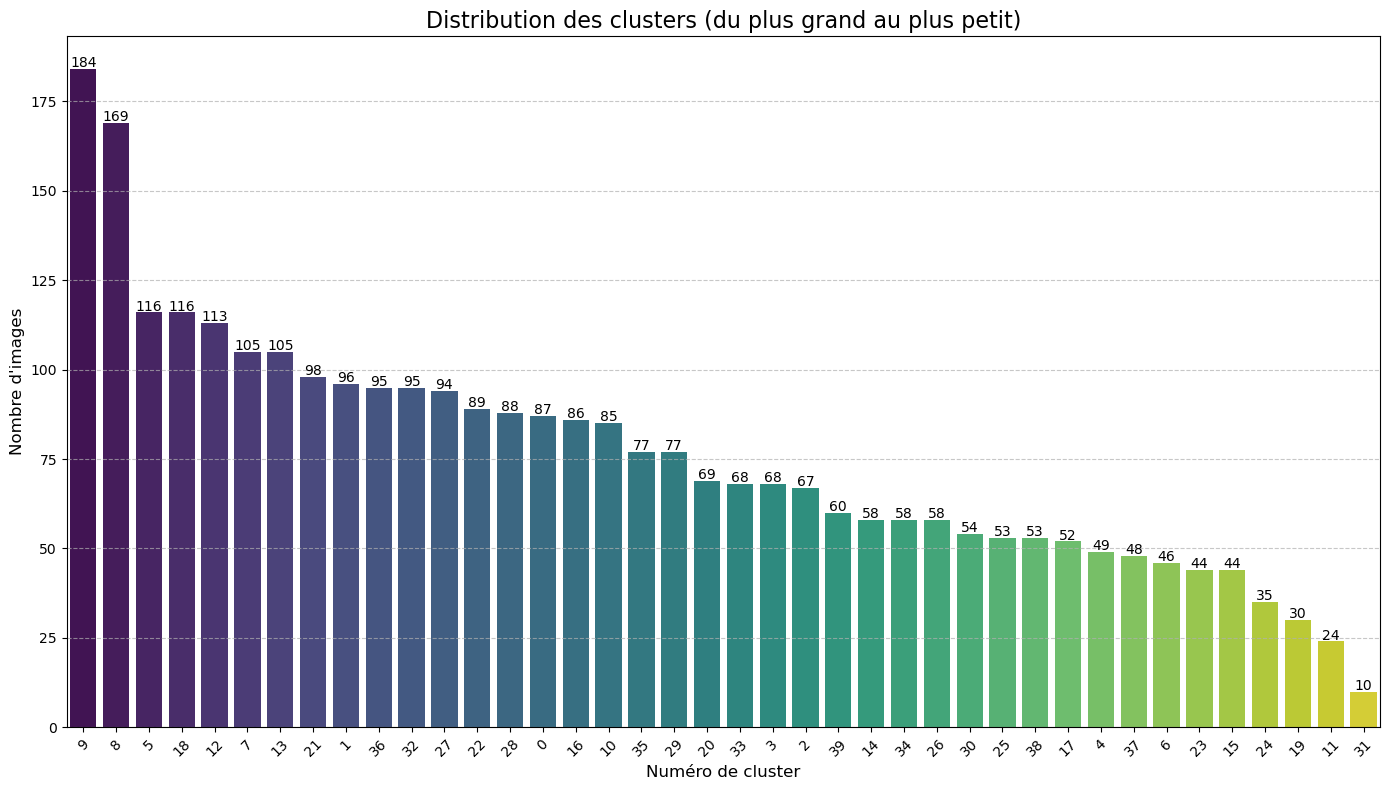

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Charger les données

# Obtenir le décompte des clusters et trier par fréquence décroissante
cluster_counts = data.loc[:,"cluster"].value_counts().sort_values(ascending=False)

# Réinitialiser l'index pour transformer cluster_counts en DataFrame
cluster_df = cluster_counts.reset_index()
cluster_df.columns = ['cluster', 'count']

# Créer un graphique à barres ordonné
# Le paramètre order permet de spécifier l'ordre des barres sur l'axe x
plt.figure(figsize=(14, 8))
sns.barplot(x='cluster', y='count', data=cluster_df, 
            order=cluster_df['cluster'], # Important : utiliser cette liste triée pour l'ordre
            palette='viridis')

# Personnaliser le graphique
plt.title('Distribution des clusters (du plus grand au plus petit)', fontsize=16)
plt.xlabel('Numéro de cluster', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Ajouter les valeurs sur chaque barre
for i, v in enumerate(cluster_df['count']):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

plt.show()

<Figure size 1400x800 with 0 Axes>

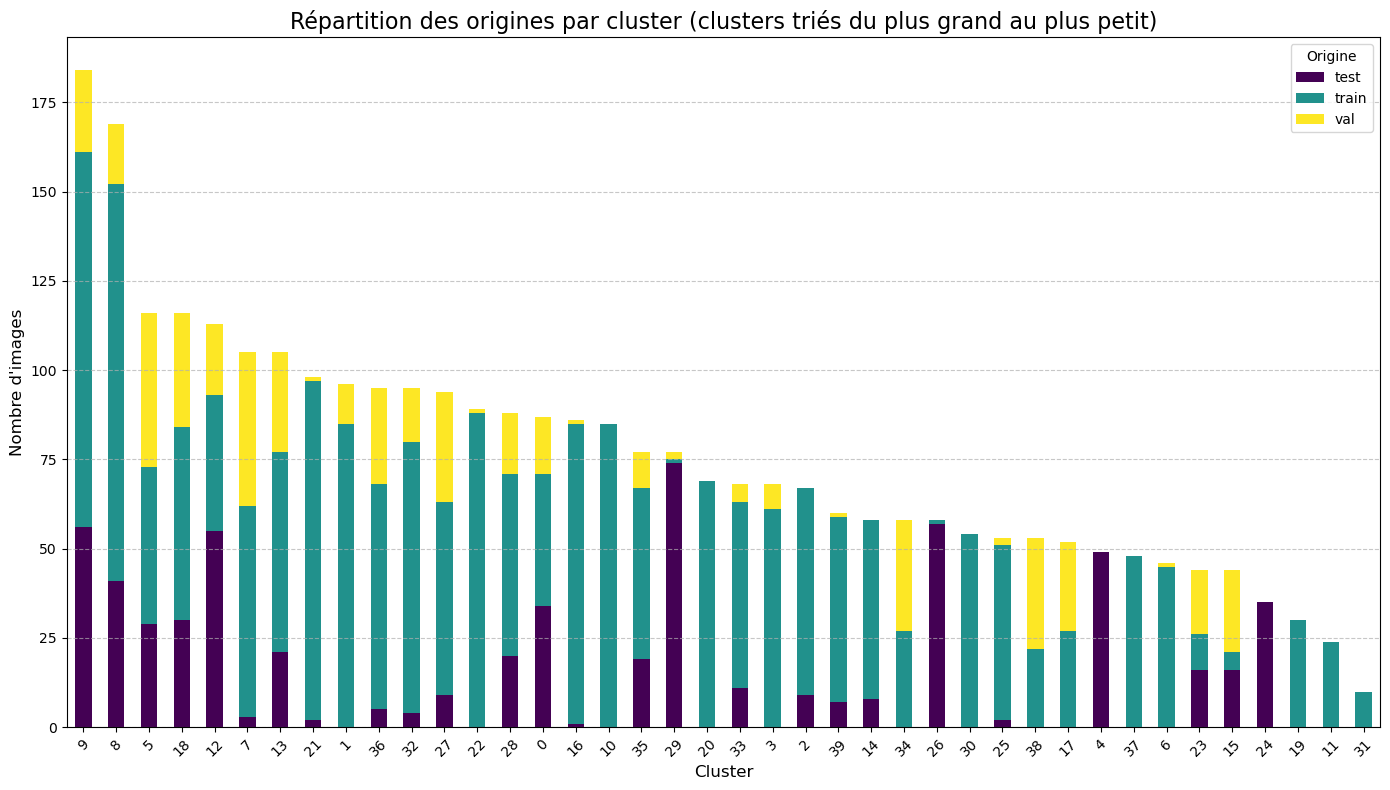

In [97]:
# Obtenir le décompte des clusters et trier par fréquence décroissante
cluster_counts = data.loc[:,"cluster"].value_counts().sort_values(ascending=False)

# Obtenir l'ordre des clusters du plus grand au plus petit
cluster_order = cluster_counts.index.tolist()

# Créer le tableau croisé
cluster_origin = pd.crosstab(data['cluster'], data['origin'])

# Réorganiser les lignes du tableau croisé selon l'ordre des clusters
cluster_origin = cluster_origin.loc[cluster_order]

# Créer le graphique à barres empilées avec l'ordre personnalisé
plt.figure(figsize=(14, 8))
cluster_origin.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))

# Personnaliser le graphique
plt.title('Répartition des origines par cluster (clusters triés du plus grand au plus petit)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Origine')
plt.tight_layout()

plt.show()

In [ ]:
from pathlib import Path
df_cluster_5 = data.loc[data["cluster"] == 5]


# je veux crée des un dossier avec le nom du cluster 
# je veus crée un dossier train , test , val dans le dossier cluster 
# je veus un dossier globale mais le nom du fichier est le nom de  l'orin sont dans le nom de l'image 

# je veus  recuperer les path 
# je veux copier les image dans leur dossier respectif 

df_cluster_5["image_path"] = df_cluster_5["image_path"].apply(Path)



folder = Path("cluster_5")
folder.mkdir(exist_ok=True)
l_origin = ["train","val","test","global"]
for origin in l_origin:
    folder_origin = folder / origin
    folder_origin.mkdir(exist_ok=True)

for index,row in df_cluster_5.iterrows():

    filename = Path(row["image_path"]).name
    if row["origin"] == "train":
        shutil.copy(row["image_path"], folder / "train" / filename)
    elif row["origin"] == "val":
        shutil.copy(row["image_path"], folder / "val" / filename)
    elif row["origin"] == "test":
        shutil.copy(row["image_path"], folder / "test" / filename)

    shutil.copy(row["image_path"], folder / "global" / f"{row['origin']}_{filename}")


/var/folders/cf/hkp86d6d1z732qc113jngvym0000gn/T/ipykernel_76936/1034913033.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_5["image_path"] = df_cluster_5["image_path"].apply(Path)
